In [1]:
# %% [markdown]
# # How to use PyTorch LSTMs for time series regression

# %% [markdown]
# # Data

# %% [markdown]
# 1. Download the Air Passengers data.
# 2. Load the Air Passengers data into a DataFrame.

# %%
import pandas as pd

df = pd.read_csv("data-sets/BTC-USD-2018-2023.csv", index_col="Date", parse_dates=True)
df.rename(columns={'#Passengers': ''}, inplace=True)

# %%
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

fig = px.line(df, labels=dict(index="Date", value="Passengers"))
fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

# %% [markdown]
# ## Create the target variable

# %%
forecast_lead = 1
target = f"lead{forecast_lead}"

df[target] = df["Passengers"].shift(-forecast_lead)
df = df.iloc[:-forecast_lead]

# %% [markdown]
# ## Create a hold-out test set and preprocess the data

# %%
test_start = "1958-01-01"

df_train = df.loc[:test_start].copy()
df_test = df.loc[test_start:].copy()

print("Test set fraction:", len(df_test) / len(df))

# %% [markdown]
# ## Standardize the features and target, based on the training set

# %%
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

df_train["Passengers"] = (df_train["Passengers"] - target_mean) / target_stdev
df_test["Passengers"] = (df_test["Passengers"] - target_mean) / target_stdev

df_train[target] = (df_train[target] - target_mean) / target_stdev
df_test[target] = (df_test[target] - target_mean) / target_stdev

# %% [markdown]
# ## Create datasets that PyTorch `DataLoader` can work with

# %%
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, sequence_length=5):
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[self.target].values).float()
        self.X = torch.tensor(dataframe['Passengers'].values).float().unsqueeze(1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]
        
# Continue the rest of the code as before


Test set fraction: 0.24475524475524477


In [2]:
# %% [markdown]
# ## Create the datasets and data loaders

# %%
from bayes_opt import BayesianOptimization, UtilityFunction
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
torch.manual_seed(101)

batch_size = 3
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))
print("Features shape:", X.shape)
print("Target shape:", y.shape)

# %% [markdown]
# # The model and learning algorithm

# %%
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_size, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()

        return out

Features shape: torch.Size([3, 3, 1])
Target shape: torch.Size([3])


In [3]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

# Define the function to be optimized
def evaluate_model(learning_rate_log, num_hidden_size, num_layers, weight_decay, batch_size):
    learning_rate = 10 ** learning_rate_log
    num_hidden_size = int(num_hidden_size)
    num_layers = int(num_layers)
    weight_decay = 10 ** weight_decay
    batch_size = int(batch_size)

    # Reinitialize the model with new parameters
    model = ShallowRegressionLSTM(hidden_size=num_hidden_size, num_layers=num_layers)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Train and test the model
    train_model(train_loader, model, loss_function, optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    
    # Return the negative test loss because BayesianOptimization maximize the function
    return -test_loss


# Define the hyperparameters range
hyperparameters_range = {
    'learning_rate_log': (-5, -2),  # we optimize in log scale
    'num_hidden_size': (1, 64),  # assuming 50 is a sensible upper limit
    'num_layers': (2, 4),  # range of layers
    'weight_decay': (-5, -2),  # weight decay in log scale
    'batch_size': (1, len(df_train))
}
# Initialize the optimizer
bayesian_optimizer = BayesianOptimization(
    f=evaluate_model,
    pbounds=hyperparameters_range,
    verbose=2,
    random_state=1
)

# Maximize the evaluation function
bayesian_optimizer.maximize(init_points=5, n_iter=100)

# Print the best parameters
print(bayesian_optimizer.max)

best_params = bayesian_optimizer.max['params']

# Re-calculate the learning rate from its logarithm
best_params['learning_rate_log'] = 10 ** best_params['learning_rate_log']

# Ensure hidden_size and num_layers are integers
best_params['num_hidden_size'] = int(round(best_params['num_hidden_size']))
best_params['num_layers'] = int(round(best_params['num_layers']))

# Train a new model with the best parameters
model = ShallowRegressionLSTM(hidden_size=best_params['num_hidden_size'], num_layers=best_params['num_layers'])
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), best_params['learning_rate_log'])

|   iter    |  target   | batch_... | learni... | num_hi... | num_la... | weight... |
-------------------------------------------------------------------------------------
Train loss: 0.9599555233443106
Test loss: 5.4819841384887695
| 1         | -5.482    | 46.04     | -2.839    | 1.007     | 2.605     | -4.56     |
Train loss: 0.8940688709954958
Test loss: 5.955228805541992
| 2         | -5.955    | 10.97     | -4.441    | 22.77     | 2.794     | -3.384    |
Train loss: 1.0792231813475892
Test loss: 6.152967631816864
| 3         | -6.153    | 46.27     | -2.944    | 13.88     | 3.756     | -4.918    |
Train loss: 1.1144888835984308
Test loss: 6.4306001762549085
| 4         | -6.431    | 73.41     | -3.748    | 36.2      | 2.281     | -4.406    |
Train loss: 0.5662313249289386
Test loss: 1.4251145394518971
| 5         | -1.425    | 87.48     | -2.095    | 20.75     | 3.385     | -2.371    |
Train loss: 0.5154625125531409
Test loss: 0.9882196436325709
| 6         | -0.9882   | 87.81   

Untrained test
--------
Test loss: 5.680697808663051

Epoch 0
---------
Train loss: 0.30685007224815924
Test loss: 1.1879057701056202

Epoch 1
---------
Train loss: 0.20473311501681
Test loss: 1.5661089196801186

Epoch 2
---------
Train loss: 0.15730988850968108
Test loss: 0.8727558869868517

Epoch 3
---------
Train loss: 0.12656136380659566
Test loss: 0.5225311828156313

Epoch 4
---------
Train loss: 0.12077456325091221
Test loss: 0.5578105685611566

Epoch 5
---------
Train loss: 0.1098213122805228
Test loss: 0.46142367646098137

Epoch 6
---------
Train loss: 0.09281888646325348
Test loss: 0.6759897371133169

Epoch 7
---------
Train loss: 0.08540668594650924
Test loss: 0.479970995336771

Epoch 8
---------
Train loss: 0.07450683708176822
Test loss: 0.47446321571866673

Epoch 9
---------
Train loss: 0.07708164036424982
Test loss: 0.296321173508962

Epoch 10
---------
Train loss: 0.07262223566303382
Test loss: 0.4045080095529556

Epoch 11
---------
Train loss: 0.07471286626910237
Test lo

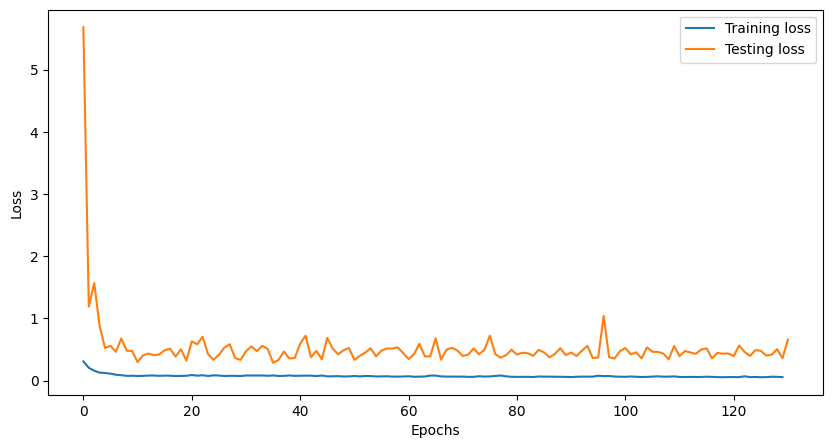

            lead1  Model forecast
Month                            
1949-01-01  118.0      124.148689
1949-02-01  132.0      129.379440
1949-03-01  129.0      140.329727
1949-04-01  121.0      134.113174
1949-05-01  135.0      130.181519
...           ...             ...
1960-07-01  606.0      532.004944
1960-08-01  508.0      471.445496
1960-09-01  461.0      373.449829
1960-10-01  390.0      358.883545
1960-11-01  432.0      317.622345

[144 rows x 2 columns]


In [4]:
# Store losses per epoch
train_losses = []
test_losses = []

print("Untrained test\n--------")
initial_test_loss = test_model(test_loader, model, loss_function)
test_losses.append(initial_test_loss)
print()


for ix_epoch in range(130):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    train_losses.append(train_loss)
    
    test_loss = test_model(test_loader, model, loss_function)
    test_losses.append(test_loss)
    print()

print("Hidden SİZE XD", model.hidden_size)

# Plot loss per epoch
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# %% [markdown]
# # Evaluation

# %%
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

# %%
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

# %%
fig = px.line(df_out, labels={'value': "Air Passengers", 'Month': 'Date'})
fig.add_vline(x=test_start, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.75, yref="paper", y=0.8, text="Test set start", showarrow=False)
fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()
# fig.write_image("air_passengers_forecast.png", width=1200, height=600)


In [5]:
from sklearn.metrics import mean_absolute_percentage_error


mape = mean_absolute_percentage_error(df_out['Model forecast'], df_out['lead1'])
mape_test = mean_absolute_percentage_error(df_out['lead1'].iloc[118:144], df_out['Model forecast'].iloc[118:144])
print("MAPE", mape)
print("Test MAPE", mape_test)



MAPE 0.09003753813396176
Test MAPE 0.14455130625093202
